# Survival Analysis in Python

Marriage and divorce data

Allen B. Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

import utils
from utils import decorate
from empyrical_dist import Pmf, Cdf, Surv, Hazard

Read the tables from [National Survey of Family Growth](https://www.cdc.gov/nchs/nsfg/index.htm), specifically [2015-2017 NSFG: Public-Use Data Files](https://www.cdc.gov/nchs/nsfg/nsfg_2015_2017_puf.htm)

[Here is the codebook](https://www.icpsr.umich.edu/icpsradmin/nsfg/index?studyNumber=10001)

And here are the data files we need.

[2015_2017_FemRespData.dat](ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Datasets/NSFG/2015_2017_FemRespData.dat)

[2015_2017_FemRespSetup.dct](ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Datasets/NSFG/stata/2015_2017_FemRespSetup.dct)


Data User's Agreement

Federal law (The Public Health Service Act (Section 308 (d))) provides that these data may be used only for the purpose of health statistical reporting and analysis. Any effort to determine the identity of any person or establishment is prohibited by this law.

NCHS does all it can to assure that the identity of data subjects cannot be disclosed. All direct identifiers, as well as any characteristics that might lead to identification, are omitted from the data files. In addition, some records have had one or more responses slightly modified through statistical perturbation. These modifications are intended to prevent definitive identification of individual respondents. They do not affect univariate point estimates and have a minimal effect on estimates of variance and tests of statistical significance.

By downloading National Survey of Family Growth data, you signify your agreement to comply with the following legal requirements:

1. To use these data for statistical reporting and analysis only;
2. To make no use of the identity of any person or establishment discovered inadvertently and advise the Director, NCHS, of any such discovery (301-458-4500); and
3. To not link these data with individually identifiable data from any other data set.

In [2]:
### To download the data, uncomment the following lines and run this cell

# !cd data
# !wget ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Datasets/NSFG/2015_2017_FemRespData.dat
# !wget ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Datasets/NSFG/stata/2015_2017_FemRespSetup.dct
# !cd ..

In [3]:
df = utils.read_stata('data/2015_2017_FemRespSetup.dct', 'data/2015_2017_FemRespData.dat')
df.head()

,CASEID,RSCRNINF,RSCRAGE,RSCRHISP,RSCRRACE,AGE_A,AGE_R,AGESCRN,HISP,HISPGRP,...,SEST,CMINTVW,CMLSTYR,CMJAN3YR,CMJAN4YR,CMJAN5YR,QUARTER,PHASE,INTVWYEAR,INTVLNGTH
0,70623,5,16,5.0,3.0,16,16,16,5,NaN,...,322,1390,1378,1345,1333,1321,17,1,2015,35.04
1,70624,1,40,5.0,1.0,40,40,40,5,NaN,...,331,1394,1382,1357,1345,1333,18,1,2016,61.01
2,70625,5,15,5.0,2.0,15,15,15,5,NaN,...,366,1402,1390,1357,1345,1333,21,1,2016,40.35
3,70627,1,35,5.0,3.0,35,35,35,5,NaN,...,322,1394,1382,1357,1345,1333,18,1,2016,64.79
4,70628,1,28,5.0,2.0,28,28,28,5,NaN,...,366,1409,1397,1369,1357,1345,23,1,2017,77.86


In [4]:
df.head()

,CASEID,RSCRNINF,RSCRAGE,RSCRHISP,RSCRRACE,AGE_A,AGE_R,AGESCRN,HISP,HISPGRP,...,SEST,CMINTVW,CMLSTYR,CMJAN3YR,CMJAN4YR,CMJAN5YR,QUARTER,PHASE,INTVWYEAR,INTVLNGTH
0,70623,5,16,5.0,3.0,16,16,16,5,NaN,...,322,1390,1378,1345,1333,1321,17,1,2015,35.04
1,70624,1,40,5.0,1.0,40,40,40,5,NaN,...,331,1394,1382,1357,1345,1333,18,1,2016,61.01
2,70625,5,15,5.0,2.0,15,15,15,5,NaN,...,366,1402,1390,1357,1345,1333,21,1,2016,40.35
3,70627,1,35,5.0,3.0,35,35,35,5,NaN,...,322,1394,1382,1357,1345,1333,18,1,2016,64.79
4,70628,1,28,5.0,2.0,28,28,28,5,NaN,...,366,1409,1397,1369,1357,1345,23,1,2017,77.86


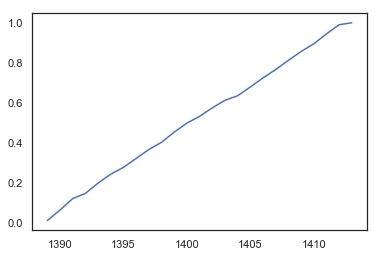

In [5]:
Cdf.from_seq(df['CMINTVW']).plot()

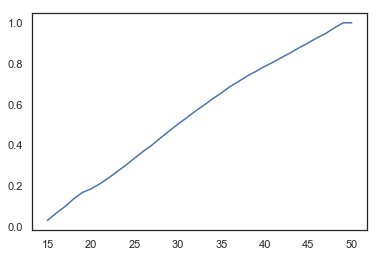

In [6]:
Cdf.from_seq(df['AGER']).plot()

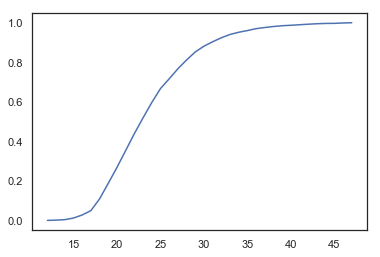

In [7]:
Cdf.from_seq(df['FMAR1AGE']).plot()

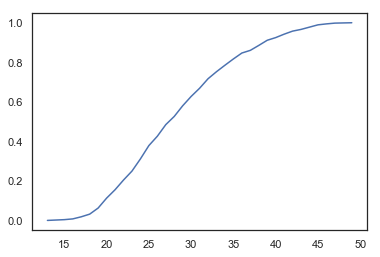

In [8]:
Cdf.from_seq(df['AGEDISS1']).plot()

In [9]:
nsfg = pd.DataFrame(index=df.index)

In [10]:
nsfg['cmintvw'] = df['CMINTVW']

In [11]:
np.random.seed(17)
def jitter_age(age):
    return age*12 + np.random.randint(0, 12, size=len(age))

In [12]:
nsfg['cmbirth'] = df['CMINTVW'] - jitter_age(df['AGER']) 

In [13]:
nsfg['cmmarr1'] = nsfg['cmbirth'] + jitter_age(df['FMAR1AGE'])

In [14]:
nsfg['cmdiss1'] = nsfg['cmbirth'] + jitter_age(df['AGEDISS1'])

In [15]:
nsfg.head()

,cmintvw,cmbirth,cmmarr1,cmdiss1
0,1390,1197,NaN,NaN
1,1394,908,1252.0,1282.0
2,1402,1216,NaN,NaN
3,1394,965,1309.0,NaN
4,1409,1073,1340.0,NaN


In [16]:
nsfg.loc[12]

cmintvw    1395.0
cmbirth    1074.0
cmmarr1    1385.0
cmdiss1       NaN
Name: 12, dtype: float64

In [17]:
df.loc[12, ['CMINTVW', 'AGER', 'FMAR1AGE']]

CMINTVW     1395.0
AGER          26.0
FMAR1AGE      25.0
Name: 12, dtype: float64

In [18]:
nsfg.to_hdf('data/nsfg.hd5', 'nsfg')

In [19]:
nsfg = pd.read_hdf('data/nsfg.hd5', 'nsfg')
nsfg.head()

,cmintvw,cmbirth,cmmarr1,cmdiss1
0,1390,1197,NaN,NaN
1,1394,908,1252.0,1282.0
2,1402,1216,NaN,NaN
3,1394,965,1309.0,NaN
4,1409,1073,1340.0,NaN
